# <center/> Basics of Mobile Robotics 
### <center/>  Thymio Robot Project

***

# 1 Introduction

For the course Basics of mobile robotics at EPFL, this project was realized as an implementation of different topics covered during lectures and exercice sessions. 

The project uses computer vision technics to transform an image detected by the X camera into a grid that is used to compute an optimal path for the Thymio robot to follow to reach its goal. 
For this to be done Global and Local navigation, Filtering and Motion control are also implemented.


## 1.1 Environment setup

For the project environment we use a black and white bordered map where the black regions represent unaccessible areas in the map. We use red color for the goal and we place a green circle on the thymio to detect it. 
Local obstacles are in white and in 3D for maximum light reflection for horizontal sensors.

An image of the environment to be added 

# 2 State diagram

A diagram representing the full system blocks to be added with an explanation.

![STATEDIAGRAM](images/state_diagram.png)



# 3 Vision



## 3.1 Vision steps and choices

First, the camera is opened and starts "reading" image by image. Every time the image is read, the position of the thymio is updated. In this report, for simplicity, only one image is saved and processed.

After reading the image, the next step is to find the four angles of the black rectangular frame on the floor. The frame was chosen to be black so that a threshold can be applied on the image. Only the black shapes then remain, and the external contour (black frame) can be extracted. 

Once the position in pixels of the corners are known, the image is transformed to a planar, rectangular image, with the black frame as borders. This configuration allows to find the position of the different elements of the environment without any deformation. 

Therefore, the procedure proceeds with the detection of the position of the goal. It is represented in the environment as a plain red circle. These shape and color were chosen to ease the recognition using already implemented packages in the cv2 library. The detection of the robot's pose is done similarly, with a blue and a green circle. The blue circle is placed exactly in the mid point between the wheels, so that the position is the most precise. The purpose of the green circle is to be able to compute the orientation of the robot with respect to the horizontal axis. 

The following step is the detection of the obstacles. This step was kept as simply as possible, by creating black, flat polygonal obstacles. By thresholding the image and transforming it to a binary image, the zero pixels will correspond to the obstacles. This new map is then resized down and given to the global navigation module. 

After initialization, only the pose of the robot is recomputed at each loop to be fed to the filtering module, contrarily to the goal and the obstacles. 


# 4 Global Navigatio/Path planning

## 4.1 Theory

For path planning we used A* as an algorithm. The grid cells are way smaller than the robot (approximately 1.5 cm compared to 10 cm). We therefore need to dilate the maze before searching for the goal using the heuristic. In coherence with our controller, we choose a dilation of 2/3 the size of the robot with a squared structure. This ensure a sufficient margin between the path and the obstacles.

The cost at each iteration (gScore) is the sum of the moving cost + a turning cost. 

The moving cost is simply $1$ when moving to a neighbour with 4N movements and $\sqrt 2 $ when moving diagonaly. 

The turning cost equals $\alpha * N$ where $N$ equals the number of time needed to turn by 45 \degrees to reach your neighbour node. This ensure a smoother path even though the controller could have handled that. It also ensure that the robot is not following the obstacles if it is shorter to do so.

As an heuristic, depending on the movements allowed (4N, 8N), we used the Manhattan or Grid distance to goal. On the picture, the green one is Manhattan and the blue one is the Grid distance. 

![DISTANCES](images/Green-line-Manhattan-distance-Red-line-euclidean-distance-Blue-line-equivalent-to-8.png)




## 4.2 Implementation


Here you can see the effect of the turning cost with different initial orientations. The goal is in red and the starting point in blue with the initial orientation.

In [7]:
import InteractGlobalNavigation as igb
igb.interact_global_navigation()

interactive(children=(ToggleButton(value=True, description='Penalize for turn'), ToggleButton(value=False, des…

# 5 Filtering

## 5.1 Theory

In this section, we are going to talk about the applied filtering, where we join multi-modal informationusing an Extended Kalman Filter to extract a better estimate of the current robot's state.

We follow the usual filter's paradigm of first computing a prediction just based on the current state $x$ and current control variables $u$ and, later on, a measurement $z$ to compare it with our prediction. In our case, we have information coming from the camera measurements and from the wheel speed readings, the first one being our measurement and the second being our defined control variables $u$ which we use to compute the prediction. 

In order to compute a good prediction, we need to use the physics of the system. Given that no torques or dynamics is applied in this problem, as we only have measurements on the pose state and in the wheels' linear velocities, we will center just on the kinematics of our robot. We are currently dealing with a Thymio, a two-wheeled robot which is a Differential Drive Robot. 

The kinematics of a Differential Drive Robot are defined by the equations defined in (https://www.cs.columbia.edu/~allen/F17/NOTES/icckinematics.pdf). If we consider that, during the time where we predict, the speeds of the wheels will not change, we can easily integrate this. The result is:

$x(t) = \frac{l(v_r + v_l)}{2(v_r-v_l)} * sin(\theta (t)) + x_0$

$y(t) = - \frac{l(v_r + v_l)}{2(v_r-v_l)} * cos(\theta (t)) + y_0$

$\theta (t) = (v_r - v_l) / l + \theta_0$

This is in fact a good approximation because we are the ones setting the control variable of the speed, and assuming a fast settling time for the wheel rotational speed, this should remain constant along the loop. 

These equations are not linear, which means that we cannot use directly the Kalman Filter. Now, there exist different choices to work on more advanced versions of the Kalman Filter. The first one is to work with a nominal trajectory and linearize around it so that we only work with small errors. However, this is not good enough because, as we will see, even if we have a desired path that we want to follow through the control, we have not completely defined the trajectory (put time in it) and we will have local avoidance in it. We end up with the next step, which is the widely used Extended Kalman Filter. We could have also used the Unscented Kalman Filter, but given the accurate measurements of the camera, we did not feel the need of using too much complexity.

From now on, we assume familiarity with the Kalman Filter. An Extended Kalman Filter works similarly to a Kalman Filter, but it uses a Prediction Function $f(x,u,t)$ and a Measurement Function $h(x)$ which do not need to be linear. Briefly put, it assumes a small uncertainty on the state so that the state predictions and uncertainty can be computed directly on the linearization of the function $f$ around the point $x,u,t$, by computing the value $f(x,u,t)$ and its Jacobian around it. It does the same for the measurement.

This type of filter needs a very good initialization and can also needs good measurements, since the errors due to the linealization can accumulate over time. If the linearization error is too big, a usual thing is to move onto a windowed smoothing or even a full smoothing paradigm. However, in our case, since we have very accurate measurements thanks to the camera, we do not need such an estimation method and a filter works perfectly.


## 5.2 Implementation



We first are going to create the synthetic trajectory, by using the kinematic equations of the robot to construct the trajectory from a given sequence of speed values.

In [8]:
import Filtering as km

import numpy as np
import matplotlib.pyplot as plt

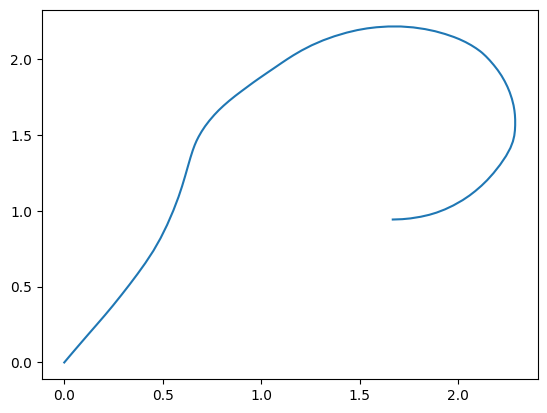

In [9]:
# Start of trajectory
x_initial = np.array([0.,0.,1.])


def trajectory(x, u, t):
    wheel_separation = 1
    V = (u[0]+u[1])/2
    w = (u[0]-u[1])/wheel_separation
    increment = np.array([
        V/w*(np.sin(t*w+x[2])-np.sin(x[2])),
        -V/w*(np.cos(t*w+x[2])-np.cos(x[2])),
        w*t
    ])
    return x + increment

np.random.seed(12345)
ind_u_data = np.random.normal(scale = 0.2, size=(100,2))
u_data = [[1,1]] + np.cumsum(ind_u_data, axis=0)
x_data = np.ones((101, 3))
v_data = np.ones((100, 2))
times = np.zeros(101)

t = 0.05

x_data[0] = x_initial

for i, u in enumerate(u_data):
    times[i+1] = times[i]+t
    x_data[i+1] = trajectory(x_data[i], u, t)
    wheel_separation = 1
    v_data[i] = np.array([(u[0]+u[1])/2,(u[0]-u[1])/wheel_separation])

x_initial[2] = 180.0/np.pi
x_data[:,2] = x_data[:,2] * 180/np.pi

# We plot our trajectory
plt.plot(x_data[:,0], x_data[:,1])

Now that the trajectory is created, we pass the exact control data to the filter. 
Since we have no measurements, we will just pass a None value as a measurement, which we have coded so as to skip the measurement step in the filter iteration.

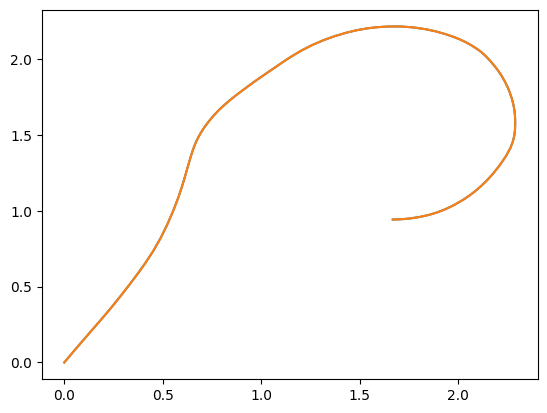

In [10]:
filter = km.create_filter(1.0, 0., 0., 10000.)

estimated_filter_data = 1.0*np.ones((101, 3))
estimated_filter_data[0] = x_initial
P = 0.05*np.eye(3)

filter.initialize(0, x_initial, P)
for i, u in enumerate(u_data):
    estimated_filter_data[i+1] = filter.iterate(u, times[i+1], None)

# We plot both trajectories
plt.plot(estimated_filter_data[:,0], estimated_filter_data[:,1])
plt.plot(x_data[:,0], x_data[:,1])

We have seen that it works as it should, predicting exactly the trajectory.

Let's now add some noise to the control data, so to simulate that what we have is not perfect.

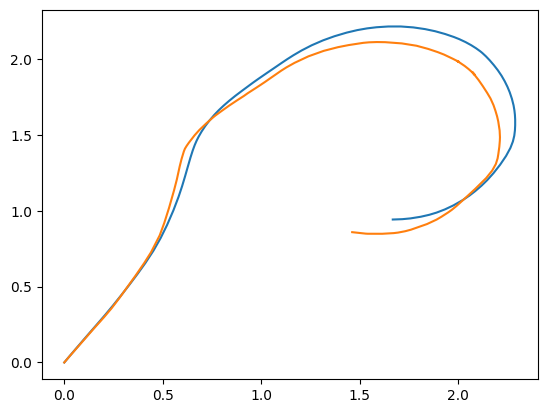

In [11]:
np.random.seed(12345)
u_data_error = u_data + np.random.normal(scale = 0.5, size=u_data.shape)

filter = km.create_filter(1.0, 0., 0.5, 100000000.)

estimated_filter_data_error = 1.0*np.ones((101, 3))
estimated_filter_data_error[0] = x_initial
P = 0.0*np.eye(3)

filter.initialize(0, x_initial, P)
for i, u in enumerate(u_data_error):
    estimated_filter_data_error[i+1] = filter.iterate(u, times[i+1], None)

plt.plot(x_data[:,0], x_data[:,1])
plt.plot(estimated_filter_data_error[:,0], estimated_filter_data_error[:,1])

Even with quite a lot of error, it works well enough. We see, however, that the errors get accumulated and the estimated trajectory is drifting.

In order to have a fully working filter, let's now add noisy measurements.

In this case, we have assumed that we know exactly the error variances.

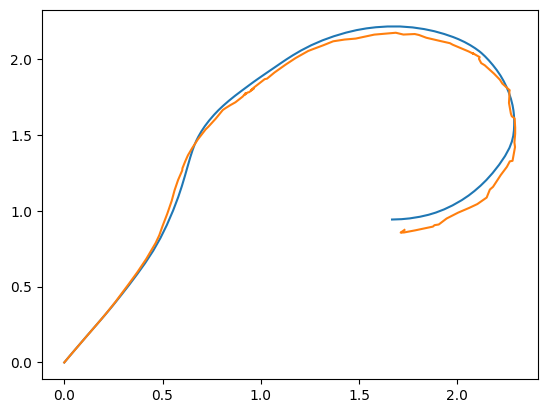

In [12]:
u_real_error_std = 0.5
meas_real_error_std = 0.2

np.random.seed(123456)

u_data_error = u_data + np.random.normal(scale = u_real_error_std, size=u_data.shape)
z_data_error = x_data + np.random.normal(scale = meas_real_error_std, size=x_data.shape)

filter = km.create_filter(1.0, 0., u_real_error_std, meas_real_error_std)

estimated_filter_data_error_meas = 1.0*np.ones((101, 3))
estimated_filter_data_error_meas[0] = x_data[0]
P = 0.0*np.eye(3)

filter.initialize(0, x_data[0],P)
for i, u in enumerate(u_data_error):
    estimated_filter_data_error_meas[i+1] = filter.iterate(u, times[i+1], z_data_error[i+1])

plt.plot(x_data[:,0], x_data[:,1])
plt.plot(estimated_filter_data_error_meas[:,0], estimated_filter_data_error_meas[:,1])

We see that with these added measurements, the estimates are better.

In a real case where the initial uncertainty would not be 0 (which is what we had earlier), the estimated trajectory would be the following.

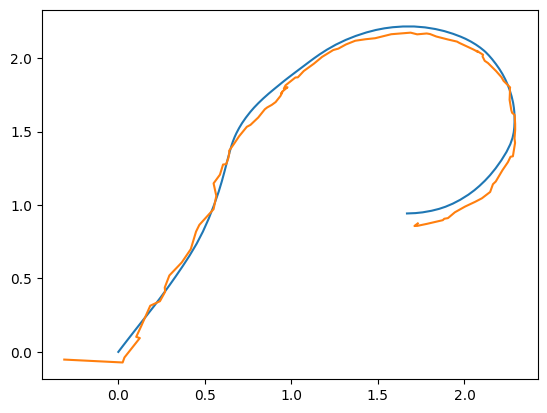

In [13]:
def plot_kalman(u_real_error_std, meas_real_error_std):

    np.random.seed(123456)

    u_data_error = u_data + np.random.normal(scale = u_real_error_std, size=u_data.shape)
    z_data_error = x_data + np.random.normal(scale = meas_real_error_std, size=x_data.shape)

    filter = km.create_filter(1.0, 0., u_real_error_std, meas_real_error_std)

    estimated_filter_data_error_meas = 1.0*np.ones((101, 3))
    estimated_filter_data_error_meas[0] = z_data_error[0]

    filter.initialize(0, z_data_error[0])
    for i, u in enumerate(u_data_error):
        estimated_filter_data_error_meas[i+1] = filter.iterate(u, times[i+1], z_data_error[i+1])

    plt.plot(x_data[:,0], x_data[:,1])
    plt.plot(estimated_filter_data_error_meas[:,0], estimated_filter_data_error_meas[:,1])

plot_kalman(0.5, 0.2)

Where we see a big variation on the first point.

Now we can try with different error types, where we will see more or less variation.

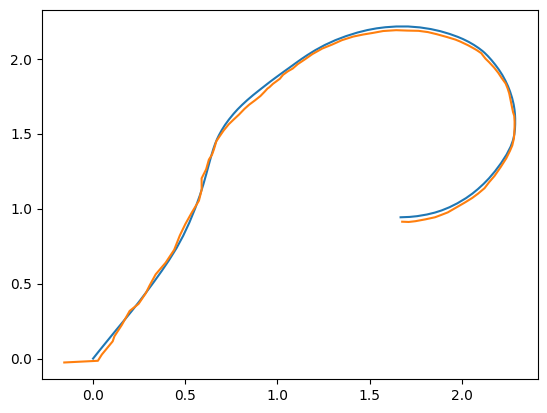

In [14]:
plot_kalman(0.1,0.1)

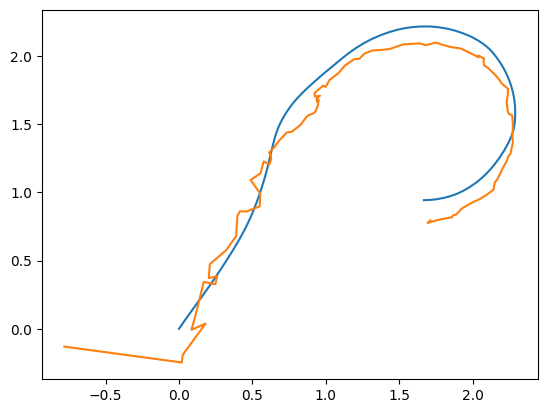

In [15]:
plot_kalman(0.5,0.5)

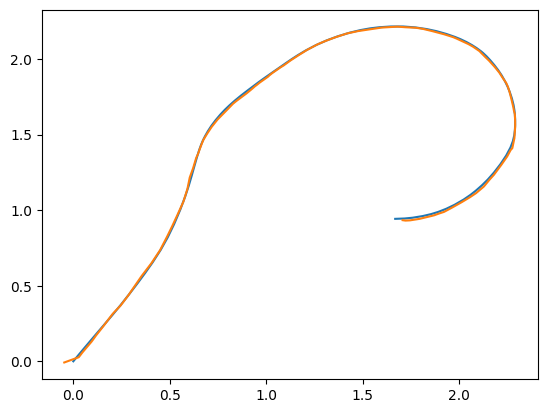

In [16]:
plot_kalman(0.3,0.03)

This last one is probably the most similar one we have to our vision-based system. 
We will now not give part of the measurements so as to simulate that, either the camera has had errors due to light or that we have blocked it, to see if our filter-based estimation would be good or not. To do so, we will just put a range of measurements to None.

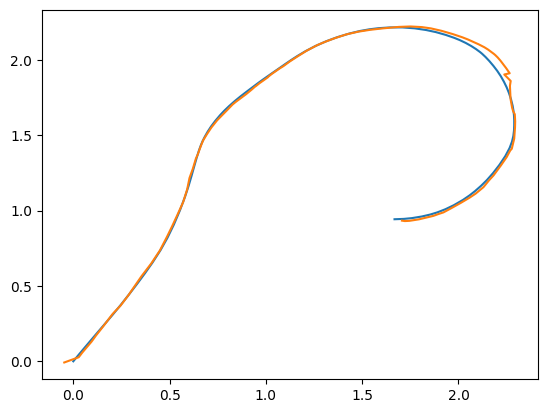

In [17]:
u_real_error_std = 0.3
meas_real_error_std = 0.03

np.random.seed(123456)

u_data_error = u_data + np.random.normal(scale = u_real_error_std, size=u_data.shape)
z_data_error = x_data + np.random.normal(scale = meas_real_error_std, size=x_data.shape)

filter = km.create_filter(1.0, 0., u_real_error_std, meas_real_error_std)

estimated_filter_data_error_meas = 1.0*np.ones((101, 3))
estimated_filter_data_error_meas[0] = z_data_error[0]

filter.initialize(0, z_data_error[0])
for i in range(50):
    estimated_filter_data_error_meas[i+1] = filter.iterate(u_data_error[i], times[i+1], z_data_error[i+1])

for i in range(50, 70):
    estimated_filter_data_error_meas[i+1] = filter.iterate(u_data_error[i], times[i+1], None)

for i in range(70, 100):
    estimated_filter_data_error_meas[i+1] = filter.iterate(u_data_error[i], times[i+1], z_data_error[i+1])

plt.plot(x_data[:,0], x_data[:,1])
plt.plot(estimated_filter_data_error_meas[:,0], estimated_filter_data_error_meas[:,1])


And we can see how even with a blocked camera, we would have a good prediction. This we will be able to see it with the real robot, which we will show in the demo.

# 6 Local avoidance

This module is needed for the robot to avoid local obstacles that may encounter its path without detecting the obstacle through vision or recomputing a new path towards the path. 
For this to happen we have different states that the robot can go through if Local Navigation is called in the Motion Control module.

## 6.1 Finite State Machine

<img src="images/fsm_local_nav.png" width="600"/>

## 6.2 Obstacle detection

To detect obstacles, the thymio robot uses the five front proximity sensors. The proximity sensors use radiations. It emits the radiations and receives them if reflected meaning that a wall is detected. These sensors can measure the time of flight of the radiations to know how close is the wall. The values of the sensors range from 0 (no wall detected) to 4300 (wall is very close). 
In our system we use the sum of all five front proximity sensors and compare the sum to a threshold value = 200 (judged best with trials according to the distance we found optimal to start rotating the robot away from the obstacle). 

## 6.3 Obstacle avoidance 

To avoid obstacles as explained in the finite state machine we have two senarios. We either use the proximity sensors to guide the robot away from the obstacle or we force an orientation to avoid going into black areas of the map. 
The priority given to the grid based avoidance, we check if black areas are too close to the current position of the thymio. If that is the case then we orient the robot in opposition to that black area. If no black area is close enough then the robot can avoid obstacles using proximity sensors values implemented in an Artificial Neural Network. 

### 6.3.1 Grid based avoidance

For the Grid based avoidance, we make use of the distances map computed in the Global Navigation module. This map contains the distance of a certain position on the grid away from all black areas presented in the map.
For the position of the thymio on grid and depending on the angle of the thymio we calculate the two possible next cells that the thymio go to (either left or right of his actual position). We check which direction is escaping the black zone and orient the robot towards that direction. 
It is possible for the thymio to run into a zone where it is faced by a local obstacle and on both lateral sides there is a black zone. I that case the thymio is stuck and will stop there. 

### 6.3.2  Proximity sensors based avoidance

For the proximity sensors based avoidance, the thymio uses the five front sensors to obtain the speed of the motors needed to avoid the obstacle. 
We use ANN to calculate the speed of motors: 


                        speed_left = forward_speed + y_left
                        speed_right = forward_speed + y_right                     
               with :
                        y_left = sum(wl_i * x_i)
                        y_right = sum(wr_i * x_i)  
                        
<img src="images/ann.png" width="600"/>                        

## 6.4 Return to path 

Before quiting the local navigation module, we have to make sure to bring the thymio back to his original path. To execute this we keep track of the side on which is the obstacle that we just avoided and give a differential speed to the motors so that the thymio will rotate around the obstacle to get back to its path. 
To check if the thymio is back to the path we calculate the distance from its actual position to the closest point on the path and if it is less than a certain distance than we consider it close enough to the path and leave it to the controller to continue guiding the thymio towards the goal.    

# 7. Path following: PurePursuit Controller

The controller that was implemented in this project was taken directly from:
https://wiki.purduesigbots.com/software/control-algorithms/basic-pure-pursuit.

The goal of the PurePursuit Controller is to compute the required angular velocity to stay on the path precomputed by the global navigation module. The linear velocity of the robot is therefore kept constant. This controller was specifically chosen to obtain a smooth path following trajectory, and is not well adapted to sharp turns, which are not necessarily needed in this project's environment. 

![carotte](images/carotte.gif)


## 7.1 Working principle

The working principle of this controller is quite simple. It consists in computing local goal points on the precomputed path, that the robot will always aim to reach. These local goals are always lying at a constant distance from the robot's position, called the "look-ahead distance", such that the current local goal is constantly updated and can never be reached by the robot. For each new local goal, the appropriate angular velocity to reach it is recomputed, and the corresponding speed difference between the wheels is applied to the robot. 
The local goal points are found in a very straightforward manner, by drawing an imaginary circle centered in the robot's position with the look-ahead distance as radius, and taking the intersection between this circle and the path to follow. 

![purepursuit](images/purepursuitgif.gif)

## 7.2 Implementation of the controller

The implementation of the controller follows the block diagram attached below. 
The three main steps of the algorithm are the following: find the intersection between the imaginary circle and the line between to path nodes, search and select the appropriate goal point to follow, and finally compute the turning error to find the turning velocity. 

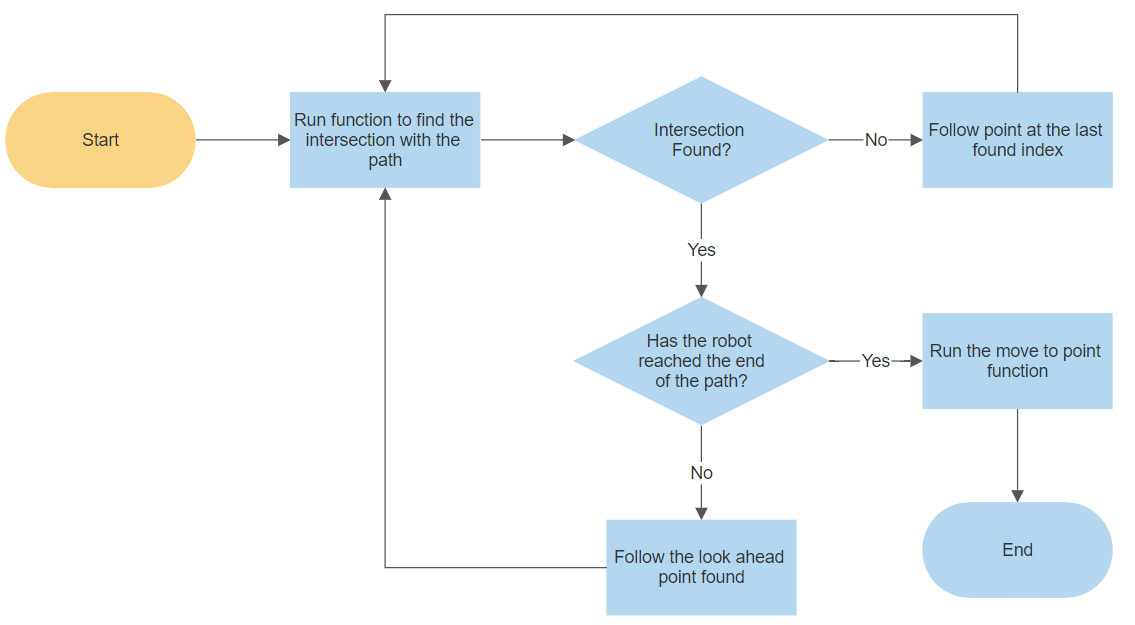

## 7.3 Parameters tuning

Two parameters need to be tuned to ensure the performance of the controller. The first one is the look-ahead distance. A too small look-ahead distance will make the robot try to follow points that are too close, and if there is some delay the controller could create oscillations. On the other hand, a too long one will cut the corners short. The second parameter is the proportional gain Kp between the computed turning error and the turning velocity. A too low gain prevents any correction of the turning error, which could induce the robot to deviate to much from the path and end up losing its sight, and a too high gain increases the speed of the output and induces oscillations in the robot's movements, because of a too high correction in the turning error, which makes the robot unstable.

# 8 Motion Control 


In the motion control module we set the speeds of the motors of the thymio according to well defined system that takes into account measurements from the Vision module runs them over the filter before feeding them to the plant depending on the state of the system that is either in normal mode using the controller or the local avoidance mode.

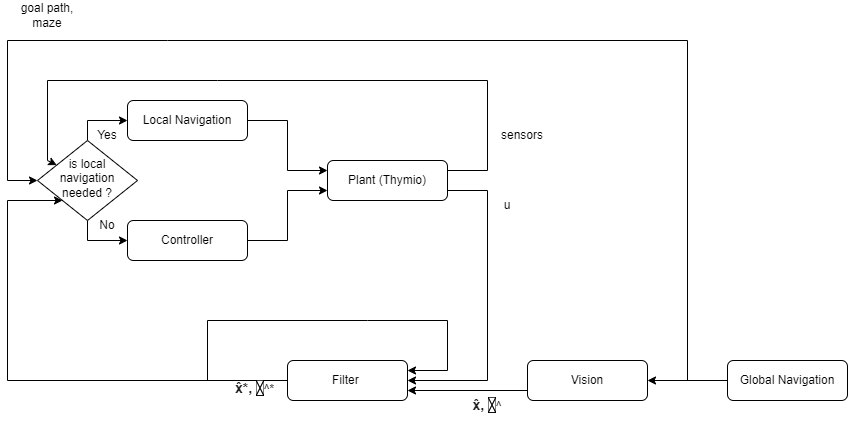



# 9 Running the all the Code



In [1]:
import Vision, GlobalNavigation, Filtering, LocalNavigation, Control, MotionControl, Robot, Print
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from tdmclient import ClientAsync, aw

In [6]:
vision = Vision.Vision()

(
    maze,
    pos_thymio,
    angle_thymio,
    goal,
) = vision.initialize_maze()

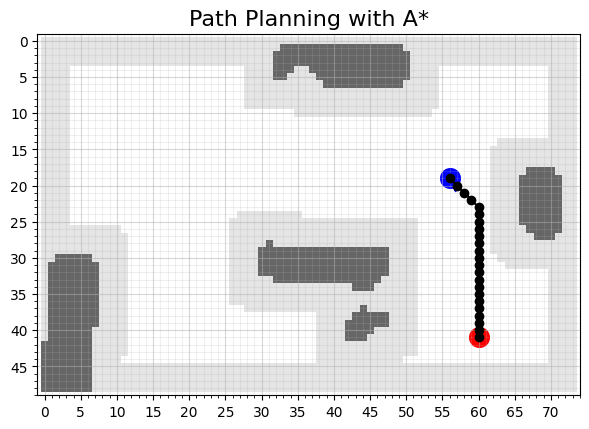

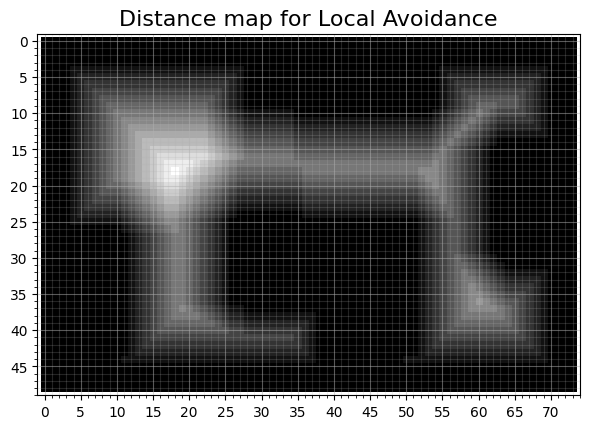

In [7]:
global_navigation = GlobalNavigation.GlobalNavigation(
    maze,
    angle_thymio,
    pos_thymio,
    goal,
    dilation=9.5/vision.get_scale_grid_to_cm()/1.5,
)

path = global_navigation.A_Star() 

client = ClientAsync()
node = await client.wait_for_node()


robot = Robot.Thymio(vision.get_scale_grid_to_cm(), node=node, client=client)  # start connection with robot
kalman_filter = Filtering.create_filter(robot.get_wheel_distance())
local_navigation = LocalNavigation.LocalNavigation(path, global_navigation.distance_map()) # map?
controller = Control.PurePursuit(path)
motion_control = MotionControl.MotionControl(
    robot, vision, kalman_filter, local_navigation, global_navigation, controller
) 

motion_control.pt.plot_path()
motion_control.pt.plot_distances_map()

In [8]:
client = ClientAsync()
node = await client.wait_for_node()



motion_control.follow_path()
robot.terminate()
vision.close_camera()  # close the camera


In the following image we can see the frame displayed once you run the cell above 

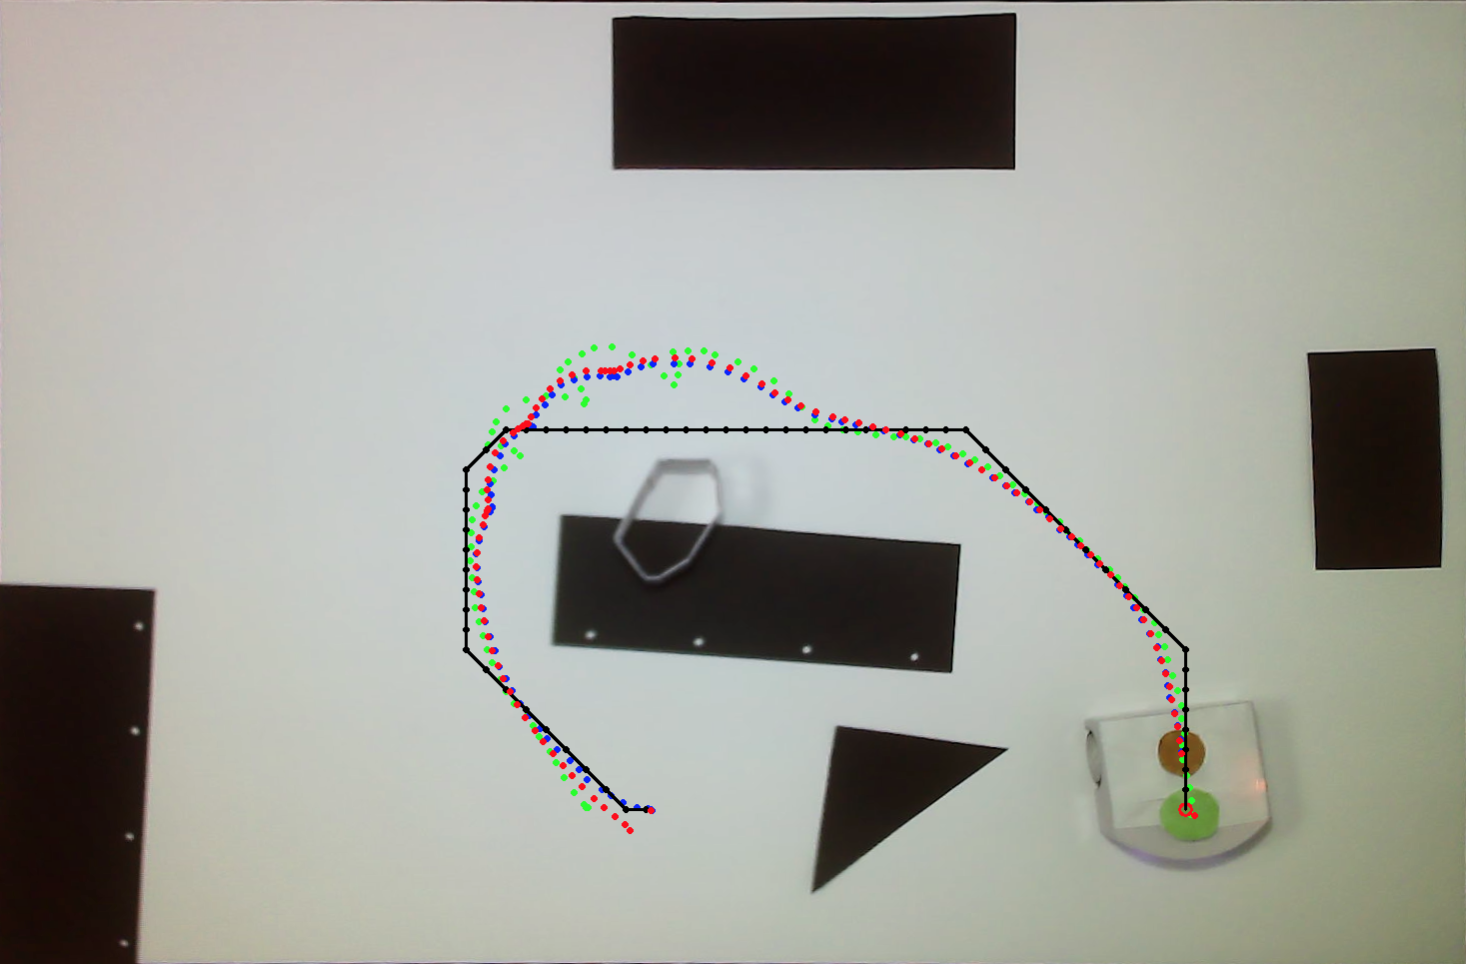

In [9]:
robot.unlock()


In [10]:
robot.lock()
robot.set_speed([0,0])
robot.unlock()

# 9 Conclusion 
 

In conclusion, the goals fixed for the realisation of this project were reached; an environment was created for the robot to evoluate in, a very specific setting with boundaries and predefined fixed obstacles. This environment was preprocessed, the positions of the different elements (obstacles, goal, position of the robot) were assessed, in order to complete the online global planning task. The best possible path was indeed found and then followed by the robot with the use of a controller, while being able to avoid potential new 3D obstacles. Meanwhile, the filtering task was equally carried, allowing to predict the pose of the robot at all times, and even to perform kidnapping and camera blinding. 
Overall, some improvements could be made, especially to make the implementation more robust. The first weak point of this implementation is the use of color detections with the camera, which is extremely sensible to changes in light and other kinds of noise. Second, when performing a "kidnapping" on the robot, only the filter and the controller are in charge, and the robot has no notion of the already existing obstacles, which it could then run over. Further, if the robot ends up in a dead end, with an obstacle in front and on the sides, it stops. The solution for those two situations would be the computation of a new global path, which would also be a bit time consuming. Indeed, the global planning could be made less time consuming, even though the A* algorithm is quite optimized. Furthermore, the controller is smooth but not extremely precise especially in sharp turns, and therefore could be improved for cases where the path needs to be really precise.  
In general, the environment was carefully chose to simplify the task; an improvement of this project would be to make the implementation robust to a more complicated environment with more elaborated features.